In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from math import ceil

## Task 3.3 - FastMap

In [31]:
X = np.load('Data/faceMatrix.npy').astype('float')
X.shape

(361, 2429)

In [32]:
# helper function to compute the squared norm of vectors
sq_norm = lambda X: (X ** 2).sum(axis=0)
# function implementing fastmap
def fastmap(
    X:np.ndarray, 
    k:int
) -> np.ndarray:
    m, n = X.shape
    # list of the computed approximations
    V = []
    # do the iterations
    for _ in range(k):
        # find the two most distant object indices
        i = np.random.choice(n, size=1)[0]
        j = sq_norm(X - X[:, i:i+1]).argmax()
        i = sq_norm(X - X[:, j:j+1]).argmax()
        j = sq_norm(X - X[:, i:i+1]).argmax()
        # approximate the major component of the current matrix X
        v = (X[:, j:j+1] - X[:, i:i+1])
        v /= la.norm(v, axis=0)
        # add the major component to the list
        V.append(v)
        # project vectors into subspace
        X = (np.eye(m) - v @ v.T) @ X
    # stack all approximations and return
    return np.concatenate(V, axis=1)

In [33]:
# compute approximations of major components using fastmap
V = fastmap(X, k=25)
V.shape

(361, 25)

In [ ]:
# compute the left singular vectors of the data matrix using svd
U, _, _ = la.svd(X)
# get only the first 25 singular vectors and ignore the rest
# note that the singular values are sorted in non-increasing order
# thus the first k singular vectors are the first k major components
U = U[:, :25]
U.shape

In [ ]:
# reshape into image format
V = V.reshape(19, 19, -1)
U = U.reshape(19, 19, -1)

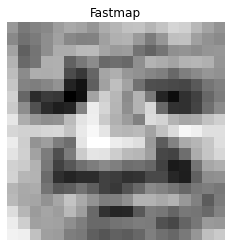

In [7]:
plt.imshow(V.sum(-1), cmap='gray')
plt.axis('off')
plt.title("Fastmap")
plt.savefig("Figures/fastmap.pdf")
plt.show()

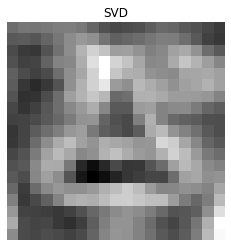

In [8]:
plt.imshow(U.sum(-1), cmap='gray')
plt.title("SVD")
plt.axis('off')
plt.savefig('Figures/svd.pdf')
plt.show()

## Task 3.4 - Hopfield Networks: k-roots

In [9]:
# signum function
signum = lambda x: np.where(x >= 0, +1, -1)
# hopfield network run asynchronous
def hopfield_run_async(s, W, theta, tmax=1000):
    for u in np.random.randint(0, s.shape[0], tmax):
        s[u] = signum(W[u, :] @ s - theta[u])
    return s
# engergy function of a hopfield network
def hopfield_energy(s, W, theta):
    return -0.5 * s.T @ W @ s + theta @ s 

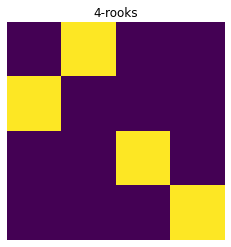

In [23]:
k = 4
m = k * k
# 4-rooks problem
# build the weight matrix
I = np.eye(k)
J = np.full((k, k), 1.) - I
W = -0.5 * np.block([
    [J, I, I, I],
    [I, J, I, I],
    [I, I, J, I],
    [I, I, I, J]
])
# build the threshold vector
theta = np.full(m, (k - 2))
# create a random initial state
s = np.random.uniform(0, 1, size=m) >= 0.5
s = 2 * s - 2
# do a few hopfield state updates
s = hopfield_run_async(s, W, theta, tmax=100)
# visualize the resulting state
plt.title("4-rooks")
plt.axis('off')
plt.imshow(s.reshape(k, k))
plt.savefig("Figures/%i-rooks.pdf" % k)
plt.show()

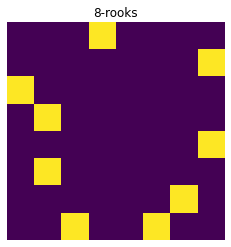

In [26]:
k = 8
m = k * k
# 4-rooks problem
# build the weight matrix
# this works for arbitrary k
I = np.eye(k)
J = np.full((k, k), 1.) - I
W = -0.5 * np.block([
    [I] * i + [J] + [I] * (k - i - 1)
    for i in range(k)
])
# build the threshold vector
theta = np.full(m, (k - 2))
# create a random initial state
s = np.random.uniform(0, 1, size=m) >= 0.5
s = 2 * s - 1
# do a few hopfield state updates
s = hopfield_run_async(s, W, theta, tmax=100)
# visualize the resulting state
plt.title("%i-rooks" % k)
plt.axis('off')
plt.imshow(s.reshape(k, k))
plt.savefig("Figures/%i-rooks.pdf" % k)
plt.show()

## Task 3.5 - Hopfield Networks: maximally different images

In [12]:
# load and preprocess data
X = np.load('Data/faceMatrix.npy').astype('float')
X = X[:, :100]
Y = X - X.mean(axis=-1, keepdims=True)
imgs = X.reshape(19, 19, -1).transpose(2, 0, 1)
X.shape

(361, 100)

In [13]:
# compute the distance matrix using method 5 from
# "NumPy/SciPy Recipes for Data Science:Squared Euclidean Distance Matrices"
# link: https://www.researchgate.net/publication/266617010_NumPy_SciPy_Recipes_for_Data_Science_Squared_Euclidean_Distance_Matrices
def squared_EDM(X:np.ndarray):
    m, n = X.shape
    # compute gram matrix
    G = X.T @ X
    # compute matrix H
    H = np.tile(np.diag(G), (n, 1))
    return H + H.T - 2*G
D = np.sqrt(squared_EDM(Y))

In [27]:
def maximally_different(
    D:np.ndarray, 
    k:int, 
    lam:float =7000
):
    # get the number of objects to choose from
    n = D.shape[0]
    # build hopfield network parameters
    W = -0.5 * (np.full((n, n), lam) - lam * np.eye(n) - D)
    theta = 0.5 * (np.full(n, lam * (n - 2*k)) - D.sum(axis=-1))
    # create an initial state
    s = np.ones(n)
    
    # apply hopfield optimization
    s = hopfield_run_async(s, W, theta, tmax=100_000)
    # create mask indicating maximally different objects
    return (s == 1.0)

def show_maximally_different(
    imgs:np.ndarray, 
    D:np.ndarray, 
    k:int
):
    mask = maximally_different(D, k=k)
    imgs = imgs[mask, ...]
    print(mask.sum())
    assert mask.sum() >= k
    # visualize
    n, m = ceil(np.sqrt(k)), int(np.sqrt(k))
    fig, axs = plt.subplots(n, m)
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        ax.imshow(imgs[i, ...], cmap='gray')
    # return the figure
    fig.tight_layout()
    return fig

12


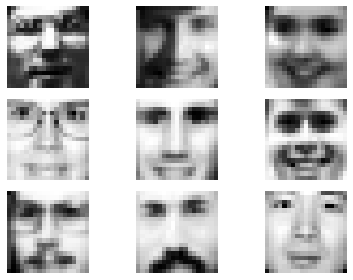

In [28]:
fig = show_maximally_different(imgs, D, k=9)
fig.savefig("Figures/imgs_k9.pdf")
plt.show()

20


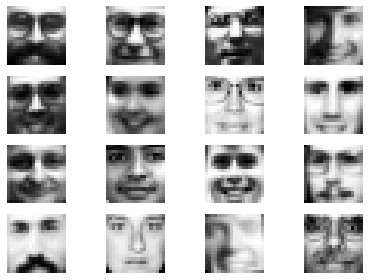

In [29]:
fig = show_maximally_different(imgs, D, k=16)
fig.savefig("Figures/imgs_k16.pdf")
plt.show()

32


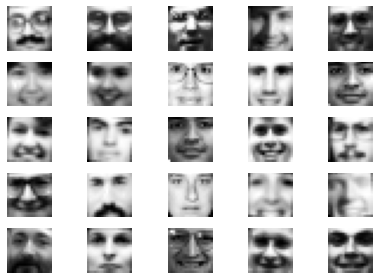

In [30]:
fig = show_maximally_different(imgs, D, k=25)
fig.savefig("Figures/imgs_k25.pdf")
plt.show()